In [ ]:
import os
import numpy as np
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import SubsetRandomSampler

# WideResNet22 - 22 Convolutional layers: model with residual blocks and batch normalization
# Residual Block adds teh original input back to the output feature map obtained by passing the input through >1 conv layers.
# CNN Augmentation with ResNet and Regularization Techniques
# 1. Data normalization - By subtracting the mean and dividing by the standard deviation across each channel.
      # As a result the mean of the data across each channel is 0, and SD is 1. This prevents the values from any one channel
      # from disproportionately affecting losses and gradients while training (due to higher or wider range of values than others)
# 2. Data augmentation
# 3. Residual Connections
# 4. Batch normalization
# 5. Learning Rate annealing
# 6. Weight Decay
# 7. Gradient Clipping

dataset_url = "http://files.fast.ai/data/examples/cifar10.tgz"
download_url(dataset_url, '.')

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
data_dir = './data/cifar10'
print(os.listdir(data_dir))
print('')
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train', 'labels.txt']

['truck', 'bird', 'deer', 'ship', 'horse', 'automobile', 'cat', 'frog', 'airplane', 'dog']


In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)
# num_workers argument can be used to leverage multiple CPU cores and load images in parallel.
# pin_memory arg avoid repeated memory allocation and deallocation by using same portion of memory (RAM) for
 # loading each batch of data.

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break

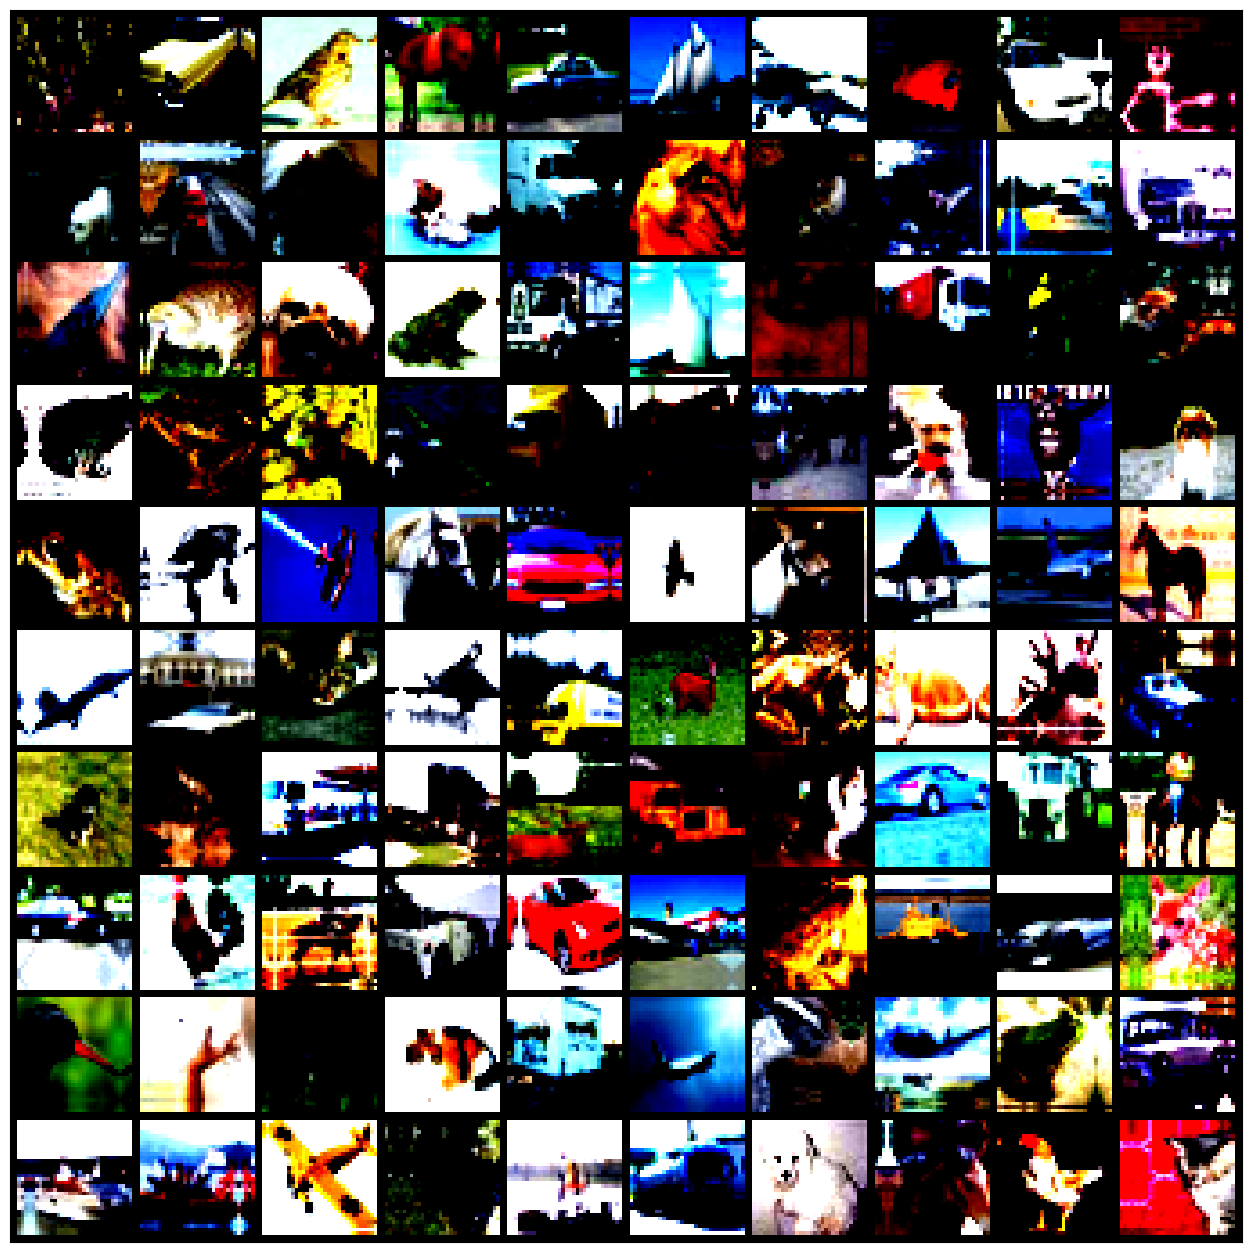

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + x)

In [ ]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
# torch.Size([256, 3, 32, 32])
# https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
# After each convolutional layer, adding a batch normalization layer.

torch.Size([256, 3, 32, 32])


In [ ]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni),
                         nn.ReLU(inplace=True),
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)

    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)



In [ ]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()  # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]

        for i in range(n_groups): # add Groups of BasicBlock(increase channels & downsample)
            n_channels.append( n_start * (2**i) *k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], n_channels[i+1], stride)

        layers += [nn.BatchNorm2d(n_channels[3]),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   Flatten(),
                   nn.Linear(n_channels[3], n_classes)]

        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)

def wrn_22():
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)


In [ ]:
model = wrn_22()

In [ ]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 10])


In [ ]:
# Learning rate scheduling refers to the process of dynamically changing the learning rate while the model is being trained.
# Among many strategies, this is 1-cycle policy. Starts with low learning rate, then gradually increases linearly to high value for about
# half of the training, then slowly brings it to original value. At end, training for few iterations with a very low learning rate
# 1-cycle: https://sgugger.github.io/the-1cycle-policy.html

In [ ]:
!pip install fastai --upgrade

In [ ]:
# Install fastai


from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.metrics import accuracy
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Assuming train_ds and valid_ds are defined
batch_size = 64
path='./data/cifar10'
# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

# # Create DataLoaders object
dls = DataLoaders(train_dl, valid_dl)

# # Define learner with correct loss function argument
learner = Learner(dls, model, loss_func=F.cross_entropy, metrics=[accuracy])#, path=path)

# # Set gradient clipping
learner.clip = 0.1
learner.save('cifar10_trained_model')
# data = DataLoader(train_ds, valid_ds, bs=batch_size, path='./data/cifar10')
# learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
# learner.clip = 0.1
# The statement learner.clip = 0.1 is used to perform gradient clipping, i.e., it limits the values of gradients to the range [-1,1],
# preventing the undesirable changes in the parameters (weights & biases) due to large gradient values.

# FastAI also provides learning rate finder, which tries a range of learning rates, and helps you select a good learning rate
# by looking at the graph of loss vs. learning rate.

Path('models/cifar10_trained_model.pth')

In [ ]:
learner.lr_find()

learner.recorder.plot_loss()
# learner.fit_one_cycle(9, 5e-3, wd=1e-4)

AttributeError: 'WideResNet' object has no attribute 'lr_find'